# Plot model performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
#from wmpgnn.model.model_loader import ModelLoader

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict): 
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def load_dataset_AsNumpy(dataset_paths):
    """
    Load the dataset from the specified path and name.
    """
    arrays = [np.load(file, allow_pickle=True).item() for file in dataset_paths]

    datasets = {}
    for k in arrays[0].keys():
        datasets[k] = np.concatenate([arr[k] for arr in arrays], axis=0)
    return datasets

In [3]:
# Define the config files to compare
configs_to_compare = {
    #"mlp_hom50": "mp_gnn_run3.yaml",
    #"mlp_hom100": "mp_gnn_run3_90k.yaml",
    "mlp_het": "heteromp_gnn_run3.yaml",
}

# Load the config files
config_loader,datasets = {},{}
for label, yml in configs_to_compare.items():
    config_loader[label] = ConfigLoader(f"config_files/{yml}", environment_prefix="DL")
    flatten_config = flatten_dict(config_loader[label].config)
    data_path = config_loader[label].get("dataset.data_dir")
    batch_size =  config_loader[label].get("training.batch_size")
    evt_max_train = config_loader[label].get("dataset.evt_max_train")
    evt_max_val = config_loader[label].get("dataset.evt_max_val")
    files_input_tr = glob.glob(f'{data_path}/training_dataset/input_*')[:evt_max_train]
    files_target_tr = glob.glob(f'{data_path}/training_dataset/target_*')[:evt_max_train]
    files_input_vl = glob.glob(f'{data_path}/validation_dataset/input_*')[:evt_max_val]
    files_target_vl = glob.glob(f'{data_path}/validation_dataset/target_*')[:evt_max_val]

    datasets[label] = {}
    for files, sample in zip(
        [files_input_tr, files_target_tr, files_input_vl, files_target_vl],
        ["input_train", "target_train", "input_val", "target_val"]
    ):
        datasets[label][sample] = load_dataset_AsNumpy(files)

In [5]:
dataset = datasets["mlp_het"]
features = dataset['input_train'].keys()

# plot features for each sample
for col in features:
    print(col, dataset['input_train'][col].shape)
    

nodes (179055, 15)
edges (23259146, 4)
senders (23259146,)
receivers (23259146,)
globals (1500,)
lca_chain (17649,)
truth_y (35298, 10)
truth_senders (35298,)
truth_receivers (35298,)
keys (179055,)
ids (11629573,)
part_ids (179055,)
truth_ids (17649,)
truth_part_ids (7718,)
truth_part_keys (7718,)


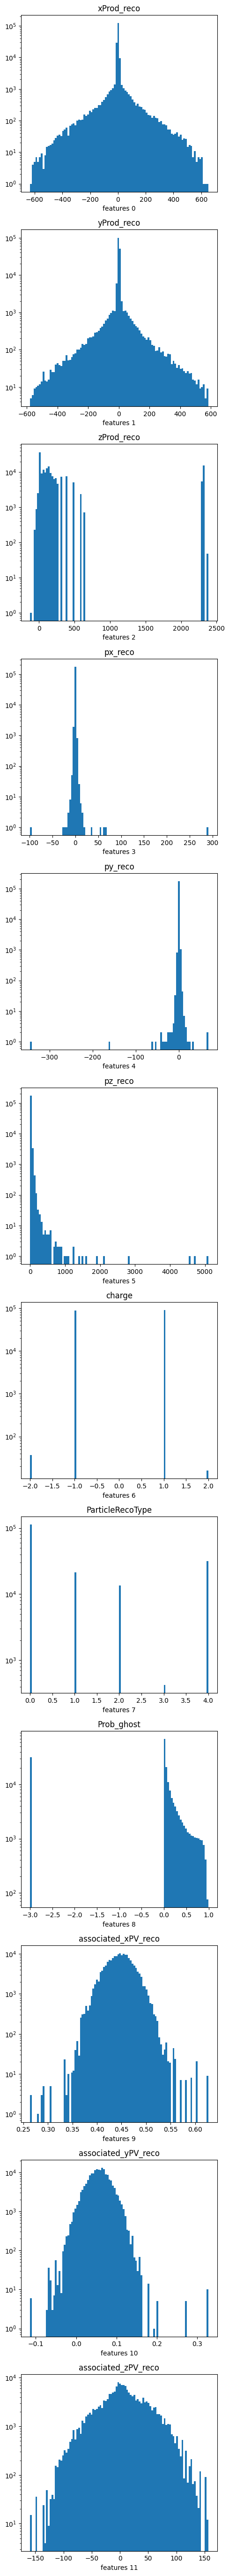

In [4]:
node_features_LCA = ['xProd_reco','yProd_reco','zProd_reco','px_reco','py_reco','pz_reco']
node_features_LCA += ['charge', 'ParticleRecoType','Prob_ghost','associated_xPV_reco', 'associated_yPV_reco', 'associated_zPV_reco']

nplots = dataset['input_train']['nodes'].shape[1]
fig,axes = plt.subplots(nplots, 1, figsize=(5, 55))
for i in range(nplots):
    axes[i].hist(dataset['input_train']['nodes'][:, i], bins=100)
    axes[i].set_title(node_features_LCA[i])
    axes[i].set_xlabel(f"features {i}")
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()
